In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import locale
import io
from dotenv import dotenv_values, load_dotenv

# Load credentials from .env file
load_dotenv()  
USERNAME, PASSWORD = dotenv_values().values()

# Set base path for API calls
BASE_URL = 'https://www-genesis.destatis.de/genesisWS/rest/2020/'

### Check login credentials

In [2]:
hello = requests.get(BASE_URL + 'helloworld/logincheck', params={
    'username': USERNAME,
    'password': PASSWORD,
    'language': 'en'
})
json.dumps(hello.json(), indent=2)

'{\n  "Status": "You have been logged in and out successfully!",\n  "Username": "hello@simonjockers.de"\n}'

### Find by search term

In [3]:
search = requests.get(BASE_URL + 'find/find', params={
    'username': USERNAME,
    'password': PASSWORD,
    'language': 'de',
    'term': 'Inflation'
})
search_results = json.loads(search.text)
search_results['Status']

{'Code': 0, 'Content': 'erfolgreich', 'Type': 'Information'}

Show results (statistics):

In [4]:
pd.DataFrame.from_dict(search_results['Statistics']).head()

,Code,Content,Cubes,Information
0,61111,Verbraucherpreisindex für Deutschland,22,true
1,61121,Harmonisierter Verbraucherpreisindex,12,true
2,61351,"Verbraucherpreisindizes Verkehr, Post, Telekomm.",22,true
3,61611,Internationaler Vergleich der Verbraucherpreise,2,true
4,99911,Internationale Indikatoren,13,false


Show results (tables):

In [5]:
pd.DataFrame.from_dict(search_results['Tables']).head(20)

,Code,Content,Time
0,61111-0001,"Verbraucherpreisindex: Deutschland, Jahre",
1,61111-0002,"Verbraucherpreisindex: Deutschland, Monate",
2,61111-0003,"Verbraucherpreisindex: Deutschland, Jahre,\nKl...",
3,61111-0004,"Verbraucherpreisindex: Deutschland, Monate,\nK...",
4,61111-0005,"Verbraucherpreisindex: Deutschland, Jahre,\nKl...",
5,61111-0006,"Verbraucherpreisindex: Deutschland, Monate,\nK...",
6,61111-0007,Wägungsschema des Verbraucherpreisindex: Deuts...,
7,61111-0010,"Verbraucherpreisindex: Bundesländer, Jahre",
8,61111-0011,"Verbraucherpreisindex: Bundesländer, Monate",
9,61111-0020,"Index der Nettokaltmieten: Bundesländer, Jahre",


#### Load table

Load table in `ffcsv` ("Flat File CSV") format:

In [6]:
response = requests.get(BASE_URL + 'data/tablefile', params={
    'username': USERNAME,
    'password': PASSWORD,
    'name': '61111-0001',
    'area': 'all',
    'compress': 'true',
    'format': 'ffcsv',
    'language': 'de'
})
print(response.text)

Statistik_Code;Statistik_Label;Zeit_Code;Zeit_Label;Zeit;1_Merkmal_Code;1_Merkmal_Label;1_Auspraegung_Code;1_Auspraegung_Label;PREIS1__Verbraucherpreisindex__2020=100;PREIS1__CH0004
61111;Verbraucherpreisindex fÃ¼r Deutschland;JAHR;Jahr;1991;DINSG;Deutschland insgesamt;DG;Deutschland;61,9;.
61111;Verbraucherpreisindex fÃ¼r Deutschland;JAHR;Jahr;1992;DINSG;Deutschland insgesamt;DG;Deutschland;65,0;+5,0
61111;Verbraucherpreisindex fÃ¼r Deutschland;JAHR;Jahr;1993;DINSG;Deutschland insgesamt;DG;Deutschland;67,9;+4,5
61111;Verbraucherpreisindex fÃ¼r Deutschland;JAHR;Jahr;1994;DINSG;Deutschland insgesamt;DG;Deutschland;69,7;+2,7
61111;Verbraucherpreisindex fÃ¼r Deutschland;JAHR;Jahr;1995;DINSG;Deutschland insgesamt;DG;Deutschland;71,0;+1,9
61111;Verbraucherpreisindex fÃ¼r Deutschland;JAHR;Jahr;1996;DINSG;Deutschland insgesamt;DG;Deutschland;72,0;+1,4
61111;Verbraucherpreisindex fÃ¼r Deutschland;JAHR;Jahr;1997;DINSG;Deutschland insgesamt;DG;Deutschland;73,4;+1,9
61111;Verbraucherpreisindex fÃ

Initialize data frame using the correct **character encoding**, **delimiter**, and **number format**: 

In [7]:
# Set encoding to unicode (utf-8)
response.encoding = 'utf-8'

# Set locale (for delocalization of values)
locale.setlocale(locale.LC_ALL, 'de_DE')

# Delocalize German number formats
def delocalize(x): 
    try: 
        return locale.atof(x)
    except ValueError: 
        return np.nan

# Read csv from response, using ';' as delimiter and ',' as decimal separator,
# also use the 'delocalize' function for the columns advanced number formats
csvInput = io.StringIO(response.text)
df = pd.read_csv(csvInput, delimiter=';', decimal=",", converters={
        'PREIS1__CH0004': delocalize
    }
)
df.head()

,Statistik_Code,Statistik_Label,Zeit_Code,Zeit_Label,Zeit,1_Merkmal_Code,1_Merkmal_Label,1_Auspraegung_Code,1_Auspraegung_Label,PREIS1__Verbraucherpreisindex__2020=100,PREIS1__CH0004
0,61111,Verbraucherpreisindex für Deutschland,JAHR,Jahr,1991,DINSG,Deutschland insgesamt,DG,Deutschland,61.9,NaN
1,61111,Verbraucherpreisindex für Deutschland,JAHR,Jahr,1992,DINSG,Deutschland insgesamt,DG,Deutschland,65.0,5.0
2,61111,Verbraucherpreisindex für Deutschland,JAHR,Jahr,1993,DINSG,Deutschland insgesamt,DG,Deutschland,67.9,4.5
3,61111,Verbraucherpreisindex für Deutschland,JAHR,Jahr,1994,DINSG,Deutschland insgesamt,DG,Deutschland,69.7,2.7
4,61111,Verbraucherpreisindex für Deutschland,JAHR,Jahr,1995,DINSG,Deutschland insgesamt,DG,Deutschland,71.0,1.9


Use data frame, e.g. to plot a chart:

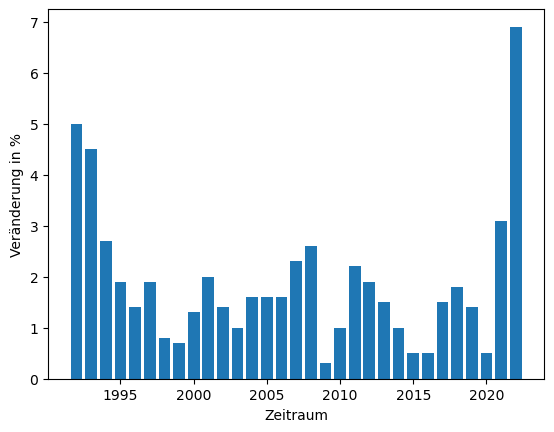

In [8]:
# Create a bar chart using the 'Zeit' and 'PREIS1__CH0004' columns
plt.bar(df['Zeit'], df['PREIS1__CH0004'])
plt.xlabel('Zeitraum')
plt.ylabel('Veränderung in %')
plt.show()